In [1]:
#либы
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import shutil
import numpy as np

from os import listdir
from os.path import isfile, join

In [3]:


class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        
        self.beta = beta

        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Квантование
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        quantized = tf.reshape(quantized, input_shape)
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices
    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.num_embeddings,
            "arg2": self.embedding_dim,
            "arg3": self.beta,
        })
        return config
    
vq_layer = VectorQuantizer(num_embeddings = 512, embedding_dim = 4, name="vector_quantizer")

image_size = 128

latent_size = int(image_size / 2**2)


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1, activation=keras.activations.swish)(x)
        x = layers.Conv2D(width/2, kernel_size=1, activation=keras.activations.swish)(x)
        x = layers.Conv2D(width/2, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=1, activation=keras.activations.swish)(x)
        x = layers.Add()([x, residual])
        return x
    return apply

#для наглядности распишу без циклов
def get_encoder(image_size):
    image = keras.Input(shape=(image_size, image_size, 3))
    
    x = image
    
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    
    #добавляем слой сильно уменьшающий кол-во фильтров (обычно до 4)
    x = layers.Conv2D(4, kernel_size=1, activation=keras.activations.swish)(x)
    
    #добавляем слой квантования
    x = vq_layer(x)    

    return keras.Model(image, x, name="encoder")

def get_decoder(latent_size):
    latent = keras.Input(shape=(latent_size, latent_size, 4))
    
    x = latent
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
    
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
    
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    
    #обратно в картинку (3 фильтра, 0...1 - sigmoid)
    x = layers.Conv2D(3, kernel_size=1, activation="sigmoid")(x)    
    
    return keras.Model(latent, x, name="decoder")

encoder = get_encoder(image_size)
decoder = get_decoder(latent_size)

encoder.load_weights("big_vqgan_encoder.h5")
decoder.load_weights("big_vqgan_decoder.h5")

In [5]:
#загрузим датасет

batch_size = 64
image_size = 128

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/users/user/ai tests/archive',
    label_mode= None,
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
    interpolation = 'area',
    seed=123
)

                                  

#препроцессинг
@tf.function
def process(x):
    #приводим значения пикселей к [0...1]
    l = encoder(x/256.0)
    return l

dataset = dataset.map(process)


Found 15747 files belonging to 1 classes.


In [6]:
#создаст tfrecord с таким названием
writer = tf.io.TFRecordWriter('cats.tfrecord')
c = 0;
for a in dataset:
    print(c)
    c+=1
    if c>100:
        break
    #сохраняем три параметра (картинка, эмбеддинг, подпись)
    serialized_a = tf.io.serialize_tensor(a).numpy()

    #создаем экземпляр
    example = tf.train.Example(features=tf.train.Features(feature={
        'a': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_a]))
    }))

    # записываем экземпляр в tfrecord файл
    writer.write(example.SerializeToString())

writer.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [7]:
#пример чтения

dataset = tf.data.TFRecordDataset('cats.tfrecord')

def parse_record(record):
    feature_description = {
        'a': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    
    a = tf.io.parse_tensor(parsed_record['a'], out_type=tf.float32)
    
    return a

dataset = dataset.map(parse_record)

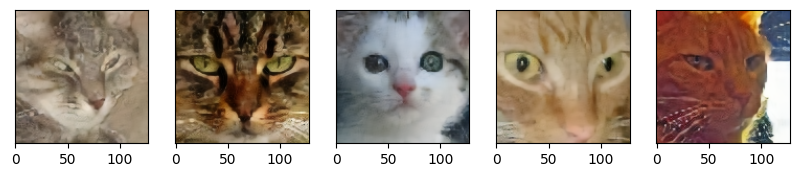

In [9]:
#посмотрим на картинки
def imshow(): 
    n = 5
    plt.figure(figsize=(10, 6))
    #берем один батч из датасета. проходимся по первым n
    for images in dataset.take(1):
        decoded_images = decoder(images)
        for i in range(n):
            img = decoded_images[i]
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow()